In [1]:
"""
Copyright 2021 Huawei Technologies Co., Ltd

CREATED:  2020-6-04 20:12:13
MODIFIED: 2021-11-25 11:48:45
"""

import os
import cv2
import numpy as np

# -*- coding:utf-8 -*-
from model.acl import Model
from PIL import Image, ImageDraw, ImageFont

In [2]:
%load_ext autoreload
%autoreload 2

In [9]:
device_id = 4

model1_path = "weights/craft.om"
model2_path = "weights/None-ResNet-None-CTC.om"

image_path = "data/images/img_11.jpg"
boxes_path = "data/polygons/res_test_305.txt"

font_path = "data/fonts/OpenSans_Condensed-SemiBold.ttf"

cropped = False
character = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
thresholds = {"text_thresh":0.7, "link_thresh":0.4, "low_text":0.4}

In [10]:
# load image
img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

In [5]:
# model1 load
model1 = Model(device_id, model1_path, thresholds = thresholds)

[ACL] init resource stage:
[ACL] init resource stage success
[MODEL] class Model init resource stage:
[MODEL] create model output dataset:
[MODEL] create model output dataset success
model input size 1
input  0
model input dims ({'name': 'input.1', 'dimCount': 4, 'dims': [1, 3, 736, 1280]}, 0)
model input datatype 0
model output size 1
output  0
model output dims ({'name': 'Transpose_86:0', 'dimCount': 4, 'dims': [1, 368, 640, 2]}, 0)
model output datatype 0
[PROCESS] init process success
[MODEL] class Model init resource stage success


In [11]:
# model1 run
bboxes = polys = None
bboxes, polys = model1.run(img_rgb)

weights/craft.om
[PreProc] image_np_expanded shape: (1, 3, 736, 1280)
[ACL] img_host_ptr, img_buf_size:  94500363107056 11304960
[ACL] img_dev_ptr, img_buf_size:  18143032377344 11304960
[MODEL] create model input dataset:
[MODEL] create model input dataset success
[MODEL] execute stage:
[MODEL] execute stage success
[RESULT] infer / postproc time : 0.073 / 0.019


In [13]:
boxes_coord = []
for poly in polys:
    poly = np.array(poly).astype(np.int32).reshape((-1))
    boxes_coord.append(poly.tolist())
    
    poly = poly.reshape(-1, 2)
    cv2.polylines(img_bgr, [poly.reshape((-1, 1, 2))], True, color=(0, 0, 255), thickness=2)
    
print(boxes_coord)

[[468, 52, 490, 52, 490, 70, 468, 70], [400, 65, 407, 64, 423, 62, 431, 60, 442, 59, 457, 58, 464, 57, 468, 71, 461, 71, 445, 73, 433, 74, 425, 75, 410, 77, 403, 78], [395, 83, 403, 81, 427, 78, 444, 75, 468, 73, 489, 68, 501, 66, 503, 82, 492, 84, 470, 89, 447, 91, 429, 94, 406, 97, 397, 98], [413, 101, 420, 100, 437, 97, 446, 96, 462, 93, 474, 92, 484, 91, 489, 105, 479, 106, 463, 107, 447, 110, 440, 111, 422, 114, 415, 115]]


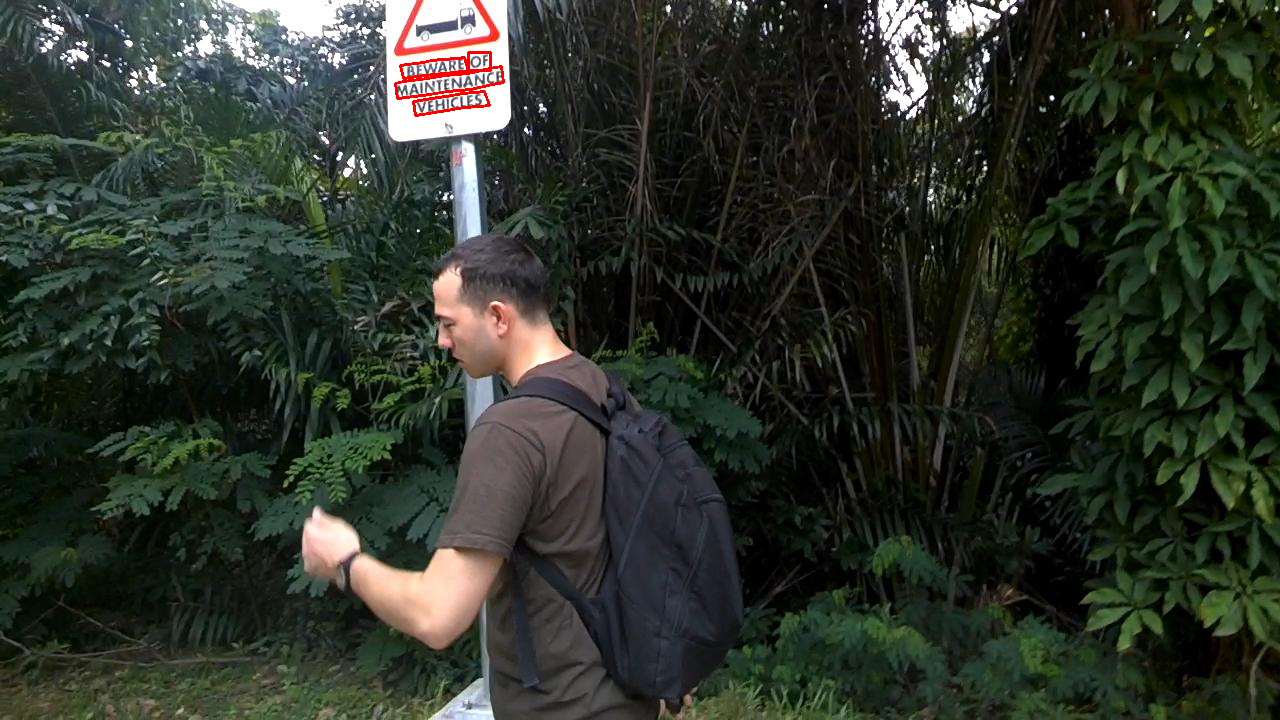

In [14]:
# show score text
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_rgb_plw = Image.fromarray(img_rgb)
img_rgb_plw

In [ ]:
# load boxes from text file
vertical_positions = None
with open(boxes_path, 'r') as bbox_f: # read coordinates of extracted bounding boxes from text file
    box_coords = [line.rstrip('\n') for line in bbox_f]
vertical_positions = np.argsort(np.asarray([int(y0.split(',')[1]) for y0 in box_coords]))

boxes_coord = []
for i in vertical_positions:
    line = box_coords[i]
    boxes_coord.append([int(i) for i in line.split(',')])
    
print(boxes_coord)

In [ ]:
# model2 load
model2 = Model(device_id, model2_path, character)

In [ ]:
# model2 run
bboxes = None
bboxes = model2.run(img_bgr, boxes_coord, cropped = cropped)

In [ ]:
# get results
img_rgb_plw = Image.fromarray(img_rgb)
s = draw = None
draw = ImageDraw.Draw(img_rgb_plw)
font = ImageFont.truetype(font_path, 18)
s = ""

for b in bboxes:
    points = b.get_points()
    arry_points = tuple(map(tuple, np.array(points).astype("int32").reshape([-1, int(len(points) / 2), 2])[0]))
    draw.polygon(arry_points, outline="red")
    draw.text((points[0], points[1]-20), b.get_text(), font=font, fill='green')
    s+=b.get_text() + " "

In [ ]:
# show outputs
img_rgb_plw

In [ ]:
# show output texts
print("[Result] image texts :", s)